In [1]:
# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [2]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

In [3]:
import phenom

In [4]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [5]:
def make_training_set(wfs, attr, scale_by_eta=False):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    
    if scale_by_eta:
        eta = phenom.eta_from_q(x)[:, np.newaxis]
        return {'x':x, 'y':y/eta}
    else:
        return {'x':x, 'y':y}

In [6]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
# q_max = 19
q_max = 2
dq = 0.25

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
t_min=-500
# t_min=-2000
t_max=75

data_to_model = 'Reh22'
# data_to_model = 'amp'
# data_to_model = 'phase'
# data_to_model = 'freq'

In [7]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [8]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts = {}
for approx in approxs:
    model_ts.update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=True)})

In [9]:
common_times = model_wfs[start_approx][0].times

In [10]:
model_ts

{'SEOBNRv4_opt': {'x': array([1.  , 1.25, 1.5 , 1.75]),
  'y': array([[ 6.20388238e-01,  6.20080857e-01,  6.18835478e-01, ...,
          -4.70388620e-03, -5.78491564e-03, -6.19738812e-03],
         [ 6.21167572e-01,  6.20857164e-01,  6.19603280e-01, ...,
          -3.40855943e-03, -4.86888677e-03, -5.72083950e-03],
         [ 6.23006985e-01,  6.22689476e-01,  6.21415378e-01, ...,
          -5.06300312e-04, -2.42844440e-03, -3.94103288e-03],
         [ 6.25478506e-01,  6.25151592e-01,  6.23850507e-01, ...,
           2.54809634e-03,  5.77984552e-04, -1.25845863e-03]])}}

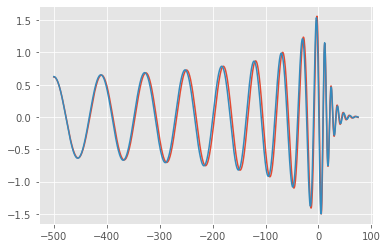

In [11]:
plt.figure()
plt.plot(common_times, model_ts[start_approx]['y'][0])
plt.plot(common_times, model_ts[start_approx]['y'][-1])

In [12]:
train_x = common_times.copy()
train_y = np.asarray([y for y in model_ts[start_approx]['y']])

train_q_labels = np.asarray([x for x in model_ts[start_approx]['x']])

In [13]:
train_y.shape

(4, 1000)

In [14]:
train_q_labels.shape

(4,)

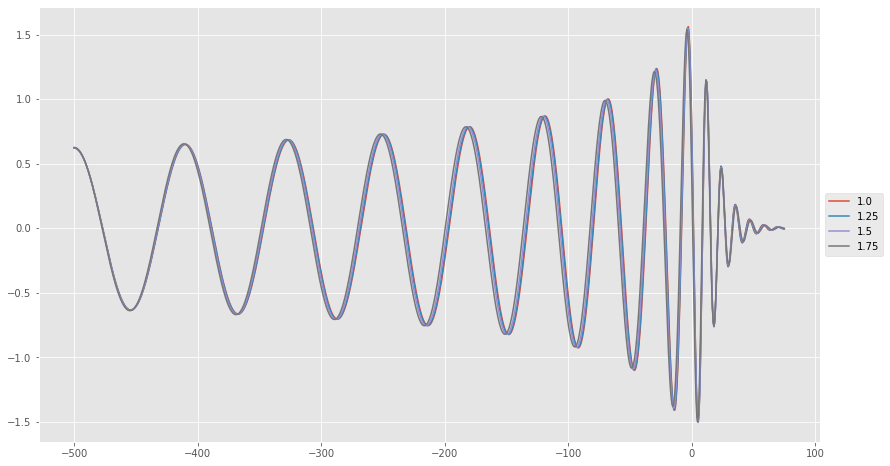

In [15]:
plt.figure(figsize=(14, 8))
for i in range(train_y.shape[0]):
    plt.plot(train_x, train_y[i], label=train_q_labels[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)

# setting up the autoencoder

In [16]:
def build_encoder(input_shape, latent_dim, act="act"):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape, ))
    x = layers.Dense(128, activation=act)(timeseries_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(16, activation=act)(x)
#     x = layers.Dense(16, activation="tanh")(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_AE = keras.Model(timeseries_input, latent_output)
#     encoder_AE.summary()
    
    return encoder_AE

In [17]:
def build_decoder(latent_dim, act="relu"):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation=act)(latent_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(128, activation=act)(x)
#     x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_AE = keras.Model(latent_input, timeseries_output)
#     decoder_AE.summary()
    
    return decoder_AE

In [18]:
def build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, learning_rate=0.01, amsgrad=False):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape, ))
    latent = encoder_AE(timeseries_input)
    timeseries_output = decoder_AE(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     ae_model.summary()
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, amsgrad=amsgrad)

    ae_model.compile(optimizer=opt, loss='mse')
    
    return ae_model

In [19]:
# latent dimension
# latent_dim = 2
latent_dim = 3
# latent_dim = 4
# latent_dim = 10
# latent_dim = 100

In [20]:
act = "relu"
# act = "tanh"

In [21]:
input_shape = train_y.shape[1] # number of time points

In [22]:
learning_rate = 0.001

In [23]:
encoder_AE = build_encoder(input_shape, latent_dim, act)
decoder_AE = build_decoder(latent_dim, act)
ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, learning_rate, amsgrad=False)

In [24]:
decoder_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              129000    
Total params: 131,240
Trainable params: 131,240
Non-trainable params: 0
_________________________________________________________________


In [25]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= 2e-8:
            self.model.stop_training = True

In [26]:
callbacks = []

In [730]:
# first_decay_steps = 40
# learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)
# callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

In [27]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

In [28]:
callbacks.append(ThresholdCallback())

In [31]:
%%time
# train the AE
ae_history = ae_model.fit(train_y, train_y, epochs=100, callbacks=callbacks, batch_size=32, verbose=0)
# , validation_split=0.2


CPU times: user 359 ms, sys: 70.8 ms, total: 430 ms
Wall time: 217 ms


In [32]:
plt.figure()
plt.plot(ae_history.history['lr'])
plt.yscale('log')

KeyError: 'lr'

<Figure size 432x288 with 0 Axes>

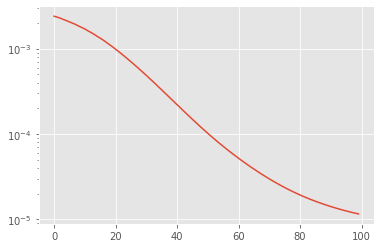

In [33]:
plt.figure()
plt.plot(ae_history.history['loss'])
# plt.plot(ae_history.history['val_loss'])
plt.yscale('log')

## check out the latent space

In [34]:
train_encodings_AE = encoder_AE.predict(train_y)

In [35]:
train_encodings_AE.shape

(4, 3)

In [36]:
train_encodings_AE

array([[ 0.12923242,  6.3810773 , -3.7127223 ],
       [ 0.3482318 ,  6.311129  , -3.9482794 ],
       [ 0.8891082 ,  6.098511  , -4.502303  ],
       [ 1.627635  ,  5.717198  , -5.2032743 ]], dtype=float32)

Text(0, 0.5, 'latent parameter')

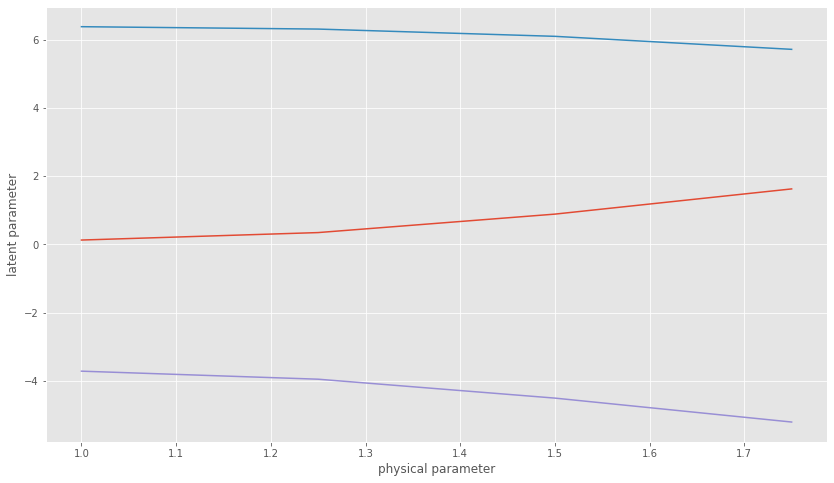

In [37]:
plt.figure(figsize=(14, 8))
plt.plot(train_q_labels, train_encodings_AE)
plt.xlabel('physical parameter')
plt.ylabel('latent parameter')

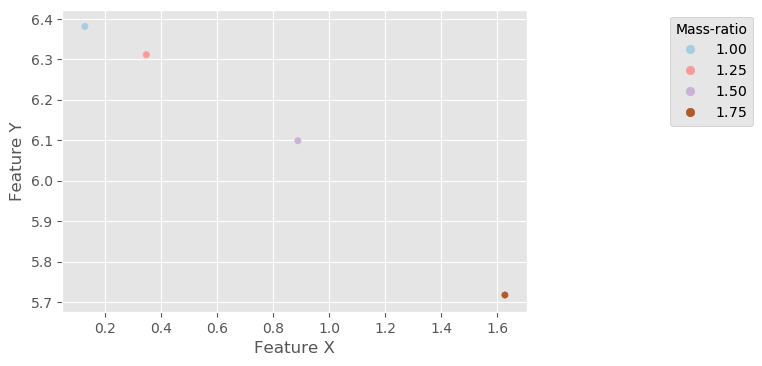

In [38]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=20, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Mass-ratio', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
#     plt.gca().set_aspect(1)
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_AE, train_q_labels)

In [39]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_AE[index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_AE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(train_x, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(train_x, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(train_x, train_y[index], lw=2)
    plt.plot(train_x, decoder_AE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_q_labels[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

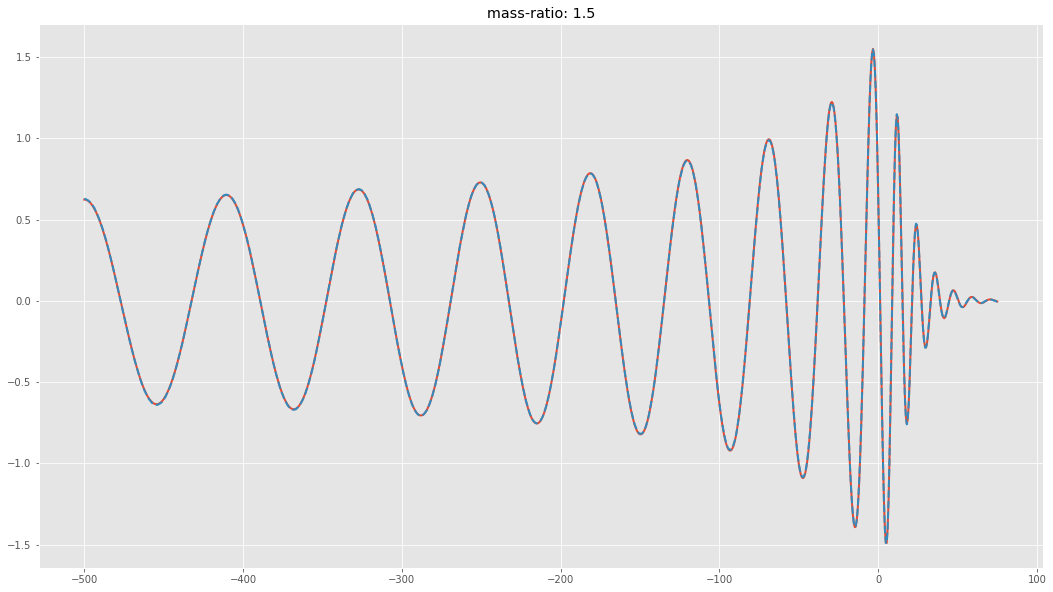

In [40]:
plot_prediction(2, n_samples=0)

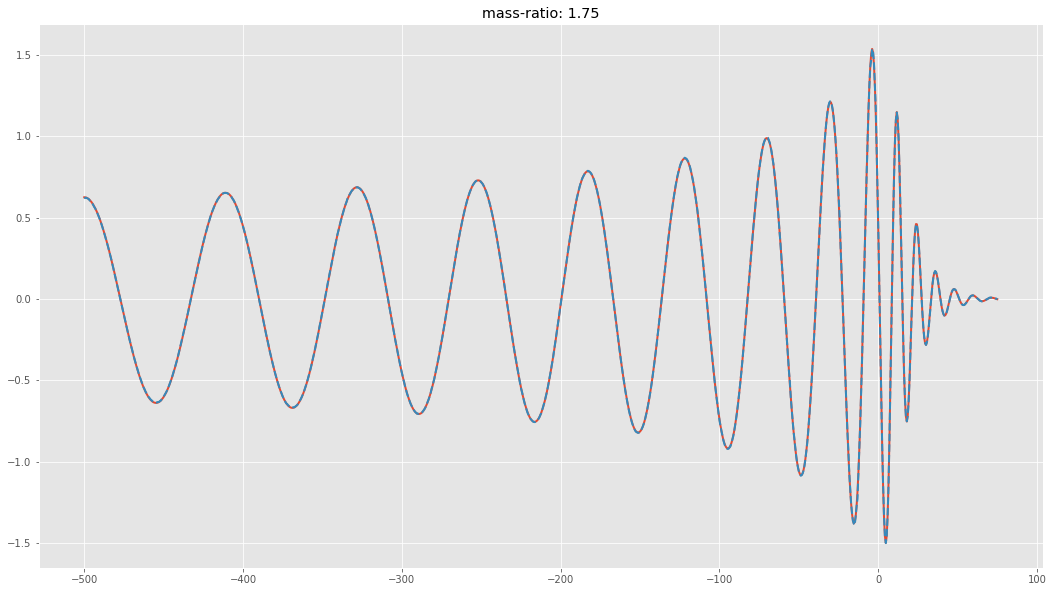

In [41]:
plot_prediction(-1, n_samples=0)

# comparing to a normal feed forward network

In [42]:
# lets make two training sets
# one less dense and another that is more dense

In [43]:
def gen_ts(dq=0.1):
    # define hyper-parameters

    # approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
    # approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
    # approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
    # approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
    approxs = ["SEOBNRv4_opt"]


    start_approx = approxs[0]
    q_min = 1
    # q_max = 19
    q_max = 2

    q_arr = np.arange(q_min, q_max, dq)

    # time points
    npts=1000
    t_min=-500
    # t_min=-2000
    t_max=75

    data_to_model = 'Reh22'
    # data_to_model = 'amp'
    # data_to_model = 'phase'
    # data_to_model = 'freq'
    model_wfs = {}
    for approx in approxs:
        model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

    # model_grb_ts: the greedy reduced basis training set for each model
    model_ts = {}
    for approx in approxs:
        model_ts.update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=True)})
        
    common_times = model_wfs[start_approx][0].times


    train_y = np.asarray([y for y in model_ts[start_approx]['y']])

    train_q = np.asarray([x for x in model_ts[start_approx]['x']])
    
    
    return common_times, train_q[:, np.newaxis], train_y

In [44]:
set1_times, set1_train_q, set1_train_y = gen_ts(dq=0.1)
set2_times, set2_train_q, set2_train_y = gen_ts(dq=0.05)

In [45]:
set1_train_q.shape

(10, 1)

In [46]:
set2_train_q.shape

(20, 1)

In [47]:
import pugna.layers
import pugna.activations

In [70]:
def build_ann(input_shape, output_shape, kernel_initializer, act="relu"):
    # build the decoder
    timeseries_input = keras.Input(shape=(input_shape,))
#     x = layers.Dense(16, activation=act)(timeseries_input)

#     x = pugna.layers.Mscale(128*4, 9, 'base2')(timeseries_input)
#     x = tf.keras.layers.Activation(pugna.activations.s2relu)(x)
    
#     x = pugna.layers.Mscale(128*4, 9, 'base2')(x)
#     x = tf.keras.layers.Activation(pugna.activations.s2relu)(x)


    x = layers.Dense(2, activation=act, kernel_initializer=kernel_initializer)(timeseries_input)
    x = layers.Dense(4, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(8, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(16, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(32, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(64, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(128, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(256, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(512, activation=act, kernel_initializer=kernel_initializer)(x)
    x = layers.Dense(1024, activation=act, kernel_initializer=kernel_initializer)(x)
#     x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    ann = keras.Model(timeseries_input, timeseries_output)
#     ann.summary()
    
    return ann

In [71]:
def build_and_compile_ann(input_shape, output_shape, kernel_initializer, act, learning_rate=0.01, amsgrad=False):
    # build the ann
    model = build_ann(input_shape, output_shape, kernel_initializer, act)
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, amsgrad=amsgrad)
#      clipvalue=0.5
#     clipnorm=1.0, 

    model.compile(optimizer=opt, loss='mse')
    
    return model

In [72]:
# act = "relu"
# act = "tanh"
act = tf.keras.layers.LeakyReLU()

In [73]:
# kernel_initializer = 'glorot_uniform'
kernel_initializer = 'glorot_normal'

# kernel_initializer = 'he_uniform'

In [74]:
input_shape = set1_train_q.shape[1] # number of features
output_shape = set1_train_y.shape[1] # number of time points

In [75]:
learning_rate = 0.001

In [76]:
ann_model = build_and_compile_ann(input_shape, output_shape, kernel_initializer, act, learning_rate, amsgrad=True)

In [77]:
ann_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_20 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_21 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              3300

In [78]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= 2e-8:
            self.model.stop_training = True

In [79]:
callbacks = []

In [80]:
# first_decay_steps = 40
# learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)
# callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

In [81]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

In [82]:
callbacks.append(ThresholdCallback())

In [83]:
%%time
# train the AE
# ann_history = ann_model.fit(train_q, train_y, epochs=1000, callbacks=callbacks, batch_size=32)
# ann_history = ann_model.fit(set1_train_q, set1_train_y, epochs=1000, callbacks=callbacks, batch_size=32)
ann_history = ann_model.fit(set2_train_q, set2_train_y, epochs=10000, callbacks=callbacks, batch_size=32, verbose=0)
# , validation_split=0.2


CPU times: user 18.1 s, sys: 2.43 s, total: 20.5 s
Wall time: 11.7 s


In [84]:
plt.figure()
plt.plot(ann_history.history['lr'])
plt.yscale('log')

KeyError: 'lr'

<Figure size 432x288 with 0 Axes>

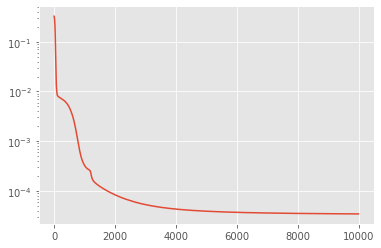

In [85]:
plt.figure()
plt.plot(ann_history.history['loss'])
# plt.plot(ann_history.history['val_loss'])
plt.yscale('log')

In [86]:
def plot_prediction_ann(index, set1_q, set1_y):
    q_true = set1_q[index][:, np.newaxis]
    
    plt.figure(figsize=(18, 10))
    
    plt.plot(set1_times, set1_y[index], lw=2)
    plt.plot(set1_times, ann_model.predict(q_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {set1_q[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

In [87]:
set1_train_q[:, np.newaxis][0]

array([[1.]])

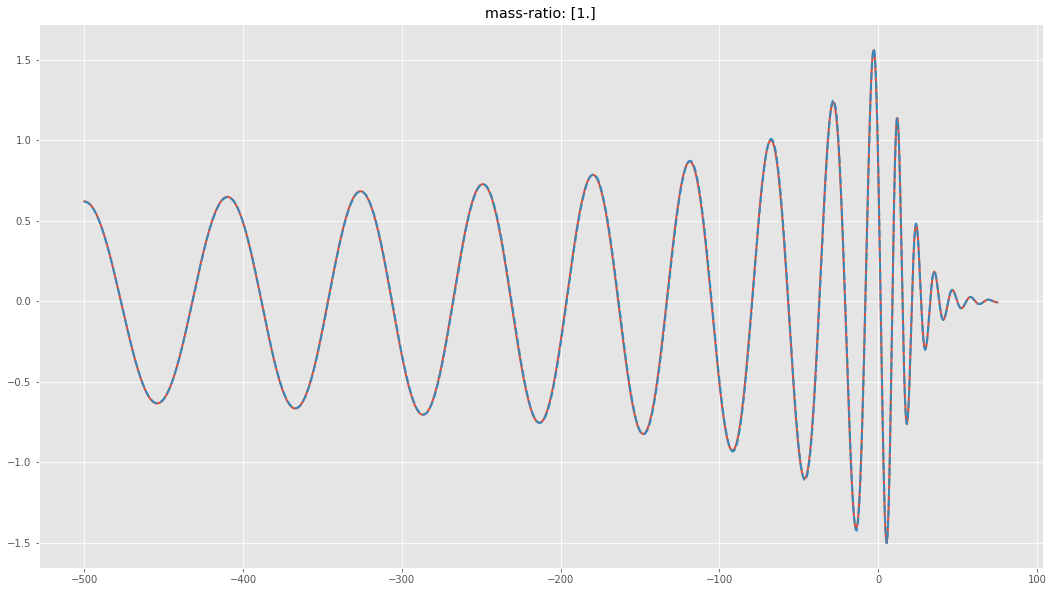

In [88]:
plot_prediction_ann(0, set1_train_q, set1_train_y)

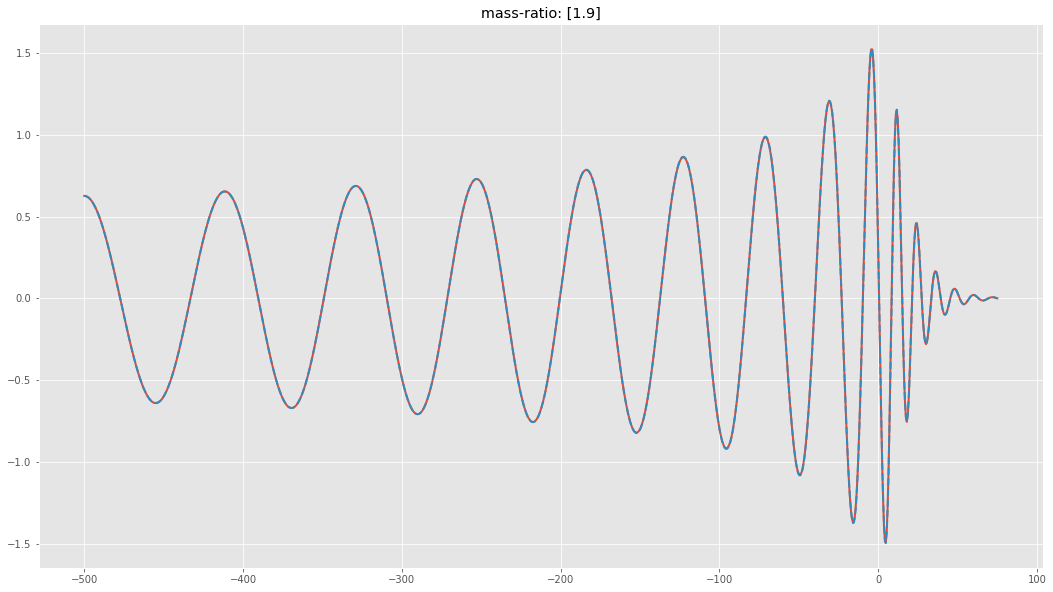

In [89]:
plot_prediction_ann(-1, set1_train_q, set1_train_y)

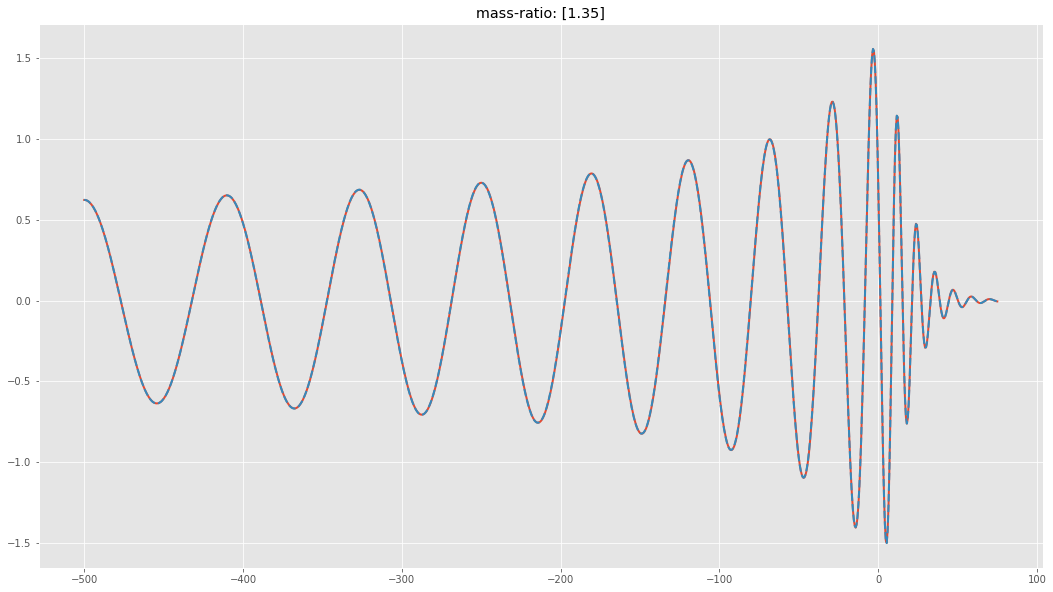

In [90]:
plot_prediction_ann(7, set2_train_q, set2_train_y)

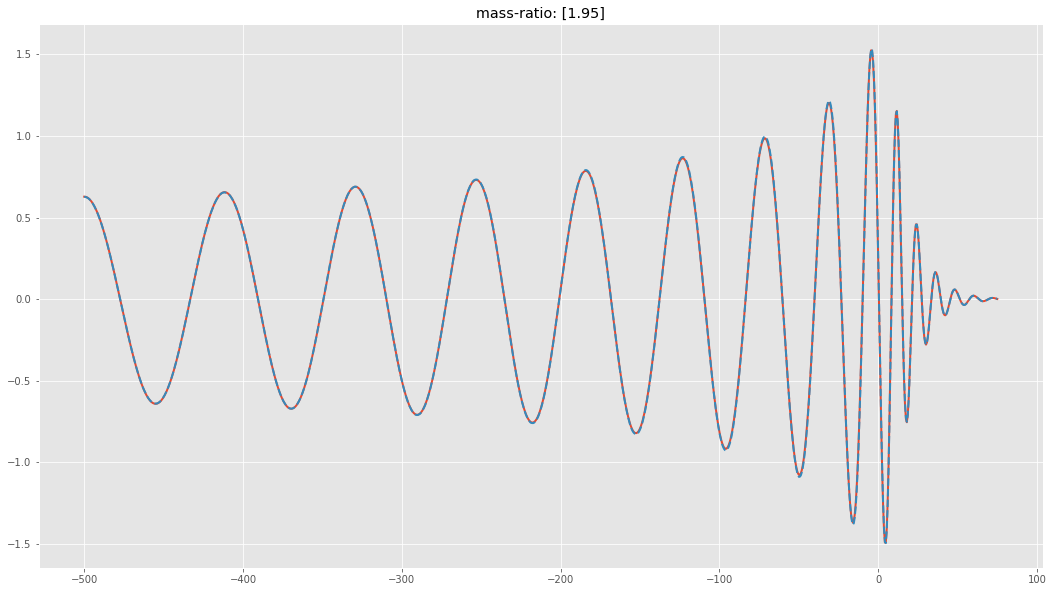

In [91]:
plot_prediction_ann(-1, set2_train_q, set2_train_y)